In [63]:
import os, sys
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
from generate_labels_summary import get_labels_synced_actigraphy_file, get_labels_columes, labels_type


# Step 1: Read the filtered actigraphy data with labels

In [64]:
subject_id = 10
which_labels = 1
labels_type = {1: "PhysicalActivity",
                2: "BehavioralPattern",
                3: "HighLevelBehavioralPattern",
                4: "Posture"}

subject_df = get_labels_synced_actigraphy_file(subject_id, which_labels, is_dominant_hand=True)
subject_df.head()

,timestamp,x_mean,x_std,x_min,x_max,x_median,x_skew,x_fft_mean,x_fft_std,x_fft_min,...,Cabinet,Putting_Clothes_Away,Lying_Still,Sweeping,Vacuuming,Watering_Plants,Lying_With_Movement,Brushing,Combing,Tying_Hair
0,1.635804e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1.635804e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.635804e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1.635804e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1.635804e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Remove all the columes except for the ones with stand, sit, walk, stair, cycling, sit, lying

In [65]:
# remove all the labels columes that do not contains stand, sit, staitr, cycling, sit, lying, run
#first get the timestamp, and the features columns
cols = subject_df.columns
# print(cols)
original_cols = [col for col in cols if col[0] == "x" or col[0] == "y" or col[0] == "z" or col == "timestamp"]
# print(original_cols)
new_subject_df = subject_df[original_cols]
final_labels = []
for labels in get_labels_columes(subject_df):
    # if labels.lower() contains any of the following words, add it to the new df
    kept_labels = ["stand", "sit", "stair", "cycling", "sit", "lying", "run"]
    for words in kept_labels:
        if words in labels.lower():
            new_subject_df[labels] = subject_df[labels]
            final_labels.append(labels)
            break

# remove all the rows that do not contain any labels
new_subject_df = new_subject_df.dropna(axis=0, how="all", subset=get_labels_columes(new_subject_df))
new_subject_df.head()

/var/folders/sd/vqw2tn057q3cyqv2p0h5zb3m0000gn/T/ipykernel_2522/1629789475.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_subject_df[labels] = subject_df[labels]
/var/folders/sd/vqw2tn057q3cyqv2p0h5zb3m0000gn/T/ipykernel_2522/1629789475.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_subject_df[labels] = subject_df[labels]
/var/folders/sd/vqw2tn057q3cyqv2p0h5zb3m0000gn/T/ipykernel_2522/1629789475.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,timestamp,x_mean,x_std,x_min,x_max,x_median,x_skew,x_fft_mean,x_fft_std,x_fft_min,...,z_fft_skew,Standing_With_Movement,Sitting_With_Movement,Walking_Down_Stairs,Walking_Up_Stairs,Cycling_Active_Pedaling_Stationary_Bike,Sitting_Still,Standing_Still,Lying_Still,Lying_With_Movement
0,1.635804e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
1,1.635804e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
2,1.635804e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
3,1.635804e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
4,1.635804e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0


Instead of making each labels a columes, change the format so that the labels are concatenate into one big dataframe, with each features are represented as one columes and one "class columes" which indicate the label.

In [66]:
#create a dataframe which only contains the timestamp and features columns
final_subject_df = pd.DataFrame()
for label in final_labels:
    label_df = new_subject_df[[col for col in new_subject_df.columns if col not in final_labels]]
    label_df[label] = new_subject_df[label]
    #drop all the row with value in the label colume is not 1
    label_df = label_df[label_df[label] == 1]
    # drop all other labels colume except the one we are working on
    label_df = label_df[[col for col in label_df.columns if col not in final_labels or col == label]]
    # add a class column and set it to the label
    label_df["class"] = label
    # drop label colume
    label_df = label_df[[col for col in label_df.columns if col != label]]
    #  add label df to the final df
    final_subject_df = final_subject_df.append(label_df)

# print out the summary number of class
print(final_subject_df["class"].value_counts())
final_subject_df.head()

Sitting_With_Movement                      24806
Standing_With_Movement                      1584
Cycling_Active_Pedaling_Stationary_Bike     1237
Lying_With_Movement                          240
Sitting_Still                                147
Lying_Still                                   41
Walking_Down_Stairs                           36
Walking_Up_Stairs                             32
Standing_Still                                 7
Name: class, dtype: int64


/var/folders/sd/vqw2tn057q3cyqv2p0h5zb3m0000gn/T/ipykernel_2522/2041032217.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df[label] = new_subject_df[label]
/var/folders/sd/vqw2tn057q3cyqv2p0h5zb3m0000gn/T/ipykernel_2522/2041032217.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_subject_df = final_subject_df.append(label_df)
/var/folders/sd/vqw2tn057q3cyqv2p0h5zb3m0000gn/T/ipykernel_2522/2041032217.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

,timestamp,x_mean,x_std,x_min,x_max,x_median,x_skew,x_fft_mean,x_fft_std,x_fft_min,...,z_max,z_median,z_skew,z_fft_mean,z_fft_std,z_fft_min,z_fft_max,z_fft_median,z_fft_skew,class
365,1.635808e+09,-0.007402,0.000726,-0.0092,-0.0050,-0.0074,0.399861,38.080136,97.900344,0.0,...,1.0102,1.0072,0.033808,82.045030,205.182314,0.0,805.7930,0.017633,3.097209,Standing_With_Movement
434,1.635808e+09,0.004365,0.000957,0.0018,0.0070,0.0044,0.144044,35.100678,97.235311,0.0,...,1.0128,1.0100,-0.066255,80.034918,205.901805,0.0,807.9898,0.019803,3.122188,Standing_With_Movement
435,1.635808e+09,0.004521,0.000971,0.0014,0.0078,0.0044,-0.010699,35.888415,97.827806,0.0,...,1.0130,1.0096,0.396023,81.114035,205.375746,0.0,807.8332,0.021979,3.127970,Standing_With_Movement
436,1.635808e+09,0.004621,0.000943,0.0020,0.0072,0.0046,0.064135,35.804447,97.494089,0.0,...,1.0128,1.0098,-0.043648,79.553877,205.826221,0.0,807.8162,0.020909,3.131052,Standing_With_Movement
437,1.635808e+09,0.004291,0.000863,0.0016,0.0064,0.0044,-0.254569,36.739151,97.391074,0.0,...,1.0122,1.0096,-0.059260,80.133028,205.765243,0.0,807.7756,0.020599,3.124302,Standing_With_Movement


In [67]:
# combining labels with stair in the name in final_subject-df
final_subject_df["class"] = final_subject_df["class"].apply(lambda x: "STAIR" if "stair" in x.lower() else x)
# combining labels with stand in the name in final_subject-df
final_subject_df["class"] = final_subject_df["class"].apply(lambda x: "STILL" if "still" in x.lower() else x)
# get the summary of class
final_subject_df["class"].value_counts()

Sitting_With_Movement                      24806
Standing_With_Movement                      1584
Cycling_Active_Pedaling_Stationary_Bike     1237
Lying_With_Movement                          240
STILL                                        195
STAIR                                         68
Name: class, dtype: int64

From the look of it, this seems to channel the summary labels files very well. I want to add one more columes to indicate the hour of the timestamp, since this might be improtant.

In [68]:
# add one columes indicating the hour of the timestamp, in EDT time
#first, we must convert timestamp to datetime (in EDT time)
final_subject_df["hour"] = pd.to_datetime(final_subject_df["timestamp"], unit="s")
final_subject_df["hour"] = final_subject_df["hour"].apply(lambda x: x.hour)
# put the hour colume in the front
cols = final_subject_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
final_subject_df = final_subject_df[cols]

final_subject_df.head()

,hour,timestamp,x_mean,x_std,x_min,x_max,x_median,x_skew,x_fft_mean,x_fft_std,...,z_max,z_median,z_skew,z_fft_mean,z_fft_std,z_fft_min,z_fft_max,z_fft_median,z_fft_skew,class
365,23,1.635808e+09,-0.007402,0.000726,-0.0092,-0.0050,-0.0074,0.399861,38.080136,97.900344,...,1.0102,1.0072,0.033808,82.045030,205.182314,0.0,805.7930,0.017633,3.097209,Standing_With_Movement
434,23,1.635808e+09,0.004365,0.000957,0.0018,0.0070,0.0044,0.144044,35.100678,97.235311,...,1.0128,1.0100,-0.066255,80.034918,205.901805,0.0,807.9898,0.019803,3.122188,Standing_With_Movement
435,23,1.635808e+09,0.004521,0.000971,0.0014,0.0078,0.0044,-0.010699,35.888415,97.827806,...,1.0130,1.0096,0.396023,81.114035,205.375746,0.0,807.8332,0.021979,3.127970,Standing_With_Movement
436,23,1.635808e+09,0.004621,0.000943,0.0020,0.0072,0.0046,0.064135,35.804447,97.494089,...,1.0128,1.0098,-0.043648,79.553877,205.826221,0.0,807.8162,0.020909,3.131052,Standing_With_Movement
437,23,1.635808e+09,0.004291,0.000863,0.0016,0.0064,0.0044,-0.254569,36.739151,97.391074,...,1.0122,1.0096,-0.059260,80.133028,205.765243,0.0,807.7756,0.020599,3.124302,Standing_With_Movement


Now, we want to use PCA to reduce the dimension of our data, and plot it the see the discriminality of the different labels.

In [69]:
# prepare the data for clustering
# first, remove the timestamp colume
final_subject_df = final_subject_df[[col for col in final_subject_df.columns if col != "timestamp"]]
# remove the class columes and save it to a variable
class_df = final_subject_df["class"]
final_subject_df = final_subject_df[[col for col in final_subject_df.columns if col != "class"]]    
# then, convert the dataframe to numpy array
final_subject_df = final_subject_df.values
# then, normalize the data
final_subject_df = preprocessing.normalize(final_subject_df)
# then, convert the numpy array to dataframe
final_subject_df = pd.DataFrame(final_subject_df)
final_subject_df.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.022550,-0.000007,7.120482e-07,-0.000009,-0.000005,-0.000007,0.000392,0.037335,0.095984,0.0,...,0.000985,0.000990,0.000987,0.000033,0.080439,0.201167,0.0,0.790024,0.000017,0.003037
1,0.022514,0.000004,9.365969e-07,0.000002,0.000007,0.000004,0.000141,0.034359,0.095181,0.0,...,0.000985,0.000991,0.000989,-0.000065,0.078344,0.201552,0.0,0.790921,0.000019,0.003056
2,0.022514,0.000004,9.507878e-07,0.000001,0.000008,0.000004,-0.000010,0.035130,0.095761,0.0,...,0.000986,0.000992,0.000988,0.000388,0.079400,0.201036,0.0,0.790763,0.000022,0.003062
3,0.022517,0.000005,9.236753e-07,0.000002,0.000007,0.000005,0.000063,0.035053,0.095449,0.0,...,0.000986,0.000992,0.000989,-0.000043,0.077885,0.201508,0.0,0.790869,0.000020,0.003065
4,0.022516,0.000004,8.447227e-07,0.000002,0.000006,0.000004,-0.000249,0.035966,0.095342,0.0,...,0.000985,0.000991,0.000988,-0.000058,0.078447,0.201436,0.0,0.790782,0.000020,0.003059


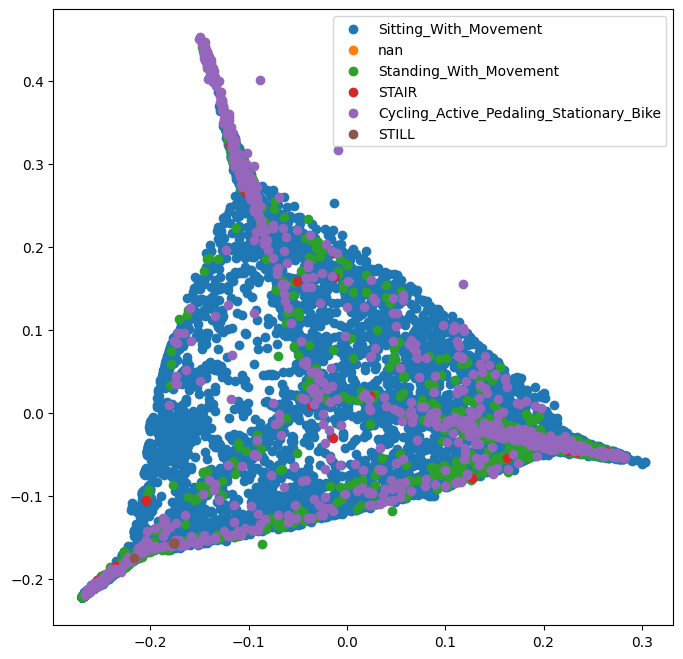

In [70]:
# perform dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(final_subject_df)
pca_final_subject_df = pca.transform(final_subject_df)

# add the class back to the dataframe
pca_final_subject_df = pd.DataFrame(pca_final_subject_df)
pca_final_subject_df["class"] = class_df

# plot the data
plt.figure(figsize=(8, 8))
for label in pca_final_subject_df["class"].unique():
    label_df = pca_final_subject_df[pca_final_subject_df["class"] == label]
    plt.scatter(label_df[0], label_df[1], label=label)
plt.legend()
plt.show()



In [71]:
# add class colume back to the final_subject-df
final_subject_df = pd.DataFrame(final_subject_df)
final_subject_df["class"] = class_df
#remove nan labels
final_subject_df = final_subject_df.dropna(axis=0, how="any", subset=["class"])

# let's try to train a classifier to predict the class
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(final_subject_df[[col for col in final_subject_df.columns if col != "class"]], final_subject_df["class"], test_size=0.2, random_state=42)

# train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# predict the class
y_pred = rf.predict(X_test)

# calculate the accuracy
accuracy_score(y_test, y_pred)

0.9060514877967235

In [72]:
# get

Sitting_With_Movement
Accuracy:  0.9969500571864277

Cycling_Active_Pedaling_Stationary_Bike
Accuracy:  0.35

Standing_With_Movement
Accuracy:  0.16574585635359115

STAIR
Accuracy:  0.0

STILL
Accuracy:  1.0

